## Electricity Price Forecasting

The aim is to predict the spot prices of electricity in several European bidding zones for short-term power trading.
The workhorse of power trading in Europe is the *day-ahead* market, with its once-per-day uniform-price auction, according to the Figure below ([source](https://doi.org/10.1016/j.apenergy.2021.116983))

![market](./imm/market.PNG)

In the day-ahead auction market, wholesale sellers and buyers submit their bids before gate closure on day $d-1$ for the delivery of electricity during day $d$. The 24 hourly prices for day $d$ are set simultaneously, typically around middday.
Several power markets exist in Europe, but the predictions here are limited to the *hourly* day-ahead spot prices of (see electricity price EDA notebook):
* Denmark (2 bidding zones)
* Great Britain (1 bidding zone)
* Italy (8 bidding zones)
* Norway (5 bidding zones)
* Sweden (4 bidding zones)

This corresponds to a total of 20 different bidding zones, or $20 \times 24 = 480$ hourly prices (targets).
The [data](https://doi.org/10.25832/time_series/2020-10-06) used for this task contains different kinds of timeseries relevant for power system modelling. Namely electricity consumption, as well as wind and solar power generation and capacities. The data is aggregated either by country, control area or bidding zone. 
Geographical coverage includes the EU and some neighbouring countries. 
All variables are provided in hourly resolution by TSOs, and power exchanges are provided via ENTSO-E Transparency, covering the period between 2015-mid 2020. 
Additional information on the available data can be found [here](https://doi.org/10.25832/time_series/2020-10-06).
Following the EDA process (see notebooks folder for the corresponding notebooks), 438 variables have been retained (excluding electricity prices) and will be used for the forecasting.
In addition, information regading national/religious holidays of the various countries has also been used ([source](https://www.timeanddate.com/)).

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

from src import config
from src import utils
from src.transformations import DiffTransform, InverseSinhTransform, PipeTransform, DimTransform
from src.models import ELM, KRR, Model
from src.preprocessing import DatasetGenerator

## Data Import and Preprocessing

The following cell reads the input data, i.e. features engineered from external predictors (see EDA notebooks), electricity prices, and national holidays. The data is split into train/test sets, with the last one year of data (2019-2020) retained as the test set.
External predictors are scaled using the median and interquantile range, and for electricity prices the inverse hyperbolic sine transform is applied, followed by first-order time-differencing. The resulting 480 time-series correspond to the targets that will be predicted.


In [3]:
# Read data
X = pd.read_csv(config.DATA_DIR + 'X_feature_engineering.csv', index_col = 0, parse_dates = True)
y = pd.read_csv(config.DATA_DIR + 'y.csv', index_col = 0, parse_dates = True)
y = y.iloc[1:, :] # remove first row (all NaNs)

# Parse holidays that were extracted from: https://www.timeanddate.com/ (accessed August 2022)
h = utils.parseHolidays(config.DATA_DIR + 'holidays.xlsx', mostCommon = 4)

# Merge and binarize categorical variables
X = X.join(h)
X = pd.get_dummies(X)

# Train / test split (the last year of data is held out)
Xtrain, Xtest, ytrain, ytest = utils.trainTestSplit(X, y, trainRatio = 4 / 5)

# Init. object that will generate a dataset per bidding zone
makeDataset = DatasetGenerator(Xtrain.columns, ytrain.columns)

# Preprocess predictors
xScaler         = RobustScaler()
Xtrain          = pd.DataFrame(xScaler.fit_transform(Xtrain.values), Xtrain.index, Xtrain.columns)
Xtest           = pd.DataFrame(xScaler.transform(Xtest.values), Xtest.index, Xtest.columns)

# Preprocess targets
trainDiffer     = DiffTransform()
testDiffer      = DiffTransform()
yTransformer    = PipeTransform(steps = [DimTransform(), InverseSinhTransform()])
ytrainTrans     = yTransformer.fit_transform(ytrain)
ytestTrans      = yTransformer.transform(ytest)
ytrainTransDiff = trainDiffer.fit_transform(ytrainTrans)
ytestTransDiff  = testDiffer.fit_transform(ytestTrans)

## Modelling

For prediction, a Kernel Ridge Regressor (KRR) and an Extreme Learning Machine (ELM) will be utilised, trained on a different dataset per bidding zone. 
More specifically, the model inputs for each bidding zone are provided by the *DatasetGenerator()* class, and they include:
* Lag-values of the (transformed) electricity prices in all bidding zones.
* Representation of solar generation, load forecast from ENTSOE transparency, wind generation (Representation is discussed in the EDA notebooks.)
* If available, a representation of onshore wind/solar generation is specifically extracted. The above are extracted for the country that the corresponding (target) bidding zones belongs to, as well as for a number of its 'closest' countries (proximity is measured as the geodesic distance between the centers of the capital cities),
* National / religion-related holiday indicators for the most frequent holiday types for each country (e.g. christmas, new-year's, easter, etc.)
* Week number and day number (of the week)

Based on this data, each model (KRR/ELM) is tuned using time-series cross validation with 4 folds on the training set.
The predictions for each target (target = electricity price of a specific bidding zone at a specific hour of every day) are obtained from the best model, i.e. the model commiting the lowest average Mean Absolute Error (MAE) on the validation sets.
No model averaging or ensembling (stacking, bagging, etc) is considered. 
All constants used in the training process are defined in the configuration file (config.py).

In [ ]:
yhat, noBidZones = [], y.shape[1]

for bidZone in range(noBidZones):

    # Models to fit
    model = Model(models = [ELM(), KRR()])

    # Make datasets for the current bidding zone
    XtrainCur, ytrainCur = makeDataset(Xtrain, ytrainTransDiff, bidZone)
    XtestCur,  ytestCur  = makeDataset(Xtest,  ytestTransDiff,  bidZone)

    # Train and compute predictions on the test set
    model.fit(XtrainCur, ytrainCur.values)
    preds = model.predict(XtestCur)
    yhat.append(preds)

# Merge predictions on all targets
yhat = pd.DataFrame(data = np.hstack(yhat), index = ytest.index, columns = ytest.columns)

# Inverse transformations
yhat += ytestTrans.shift(1)                 # This essentially inverses the diff() operation
yhat = yTransformer.inverse_transform(yhat) # Inverse the rest of the transformations (inverseSinh and dimAlign)

## Training process results

Plot the prediction results on the test set:

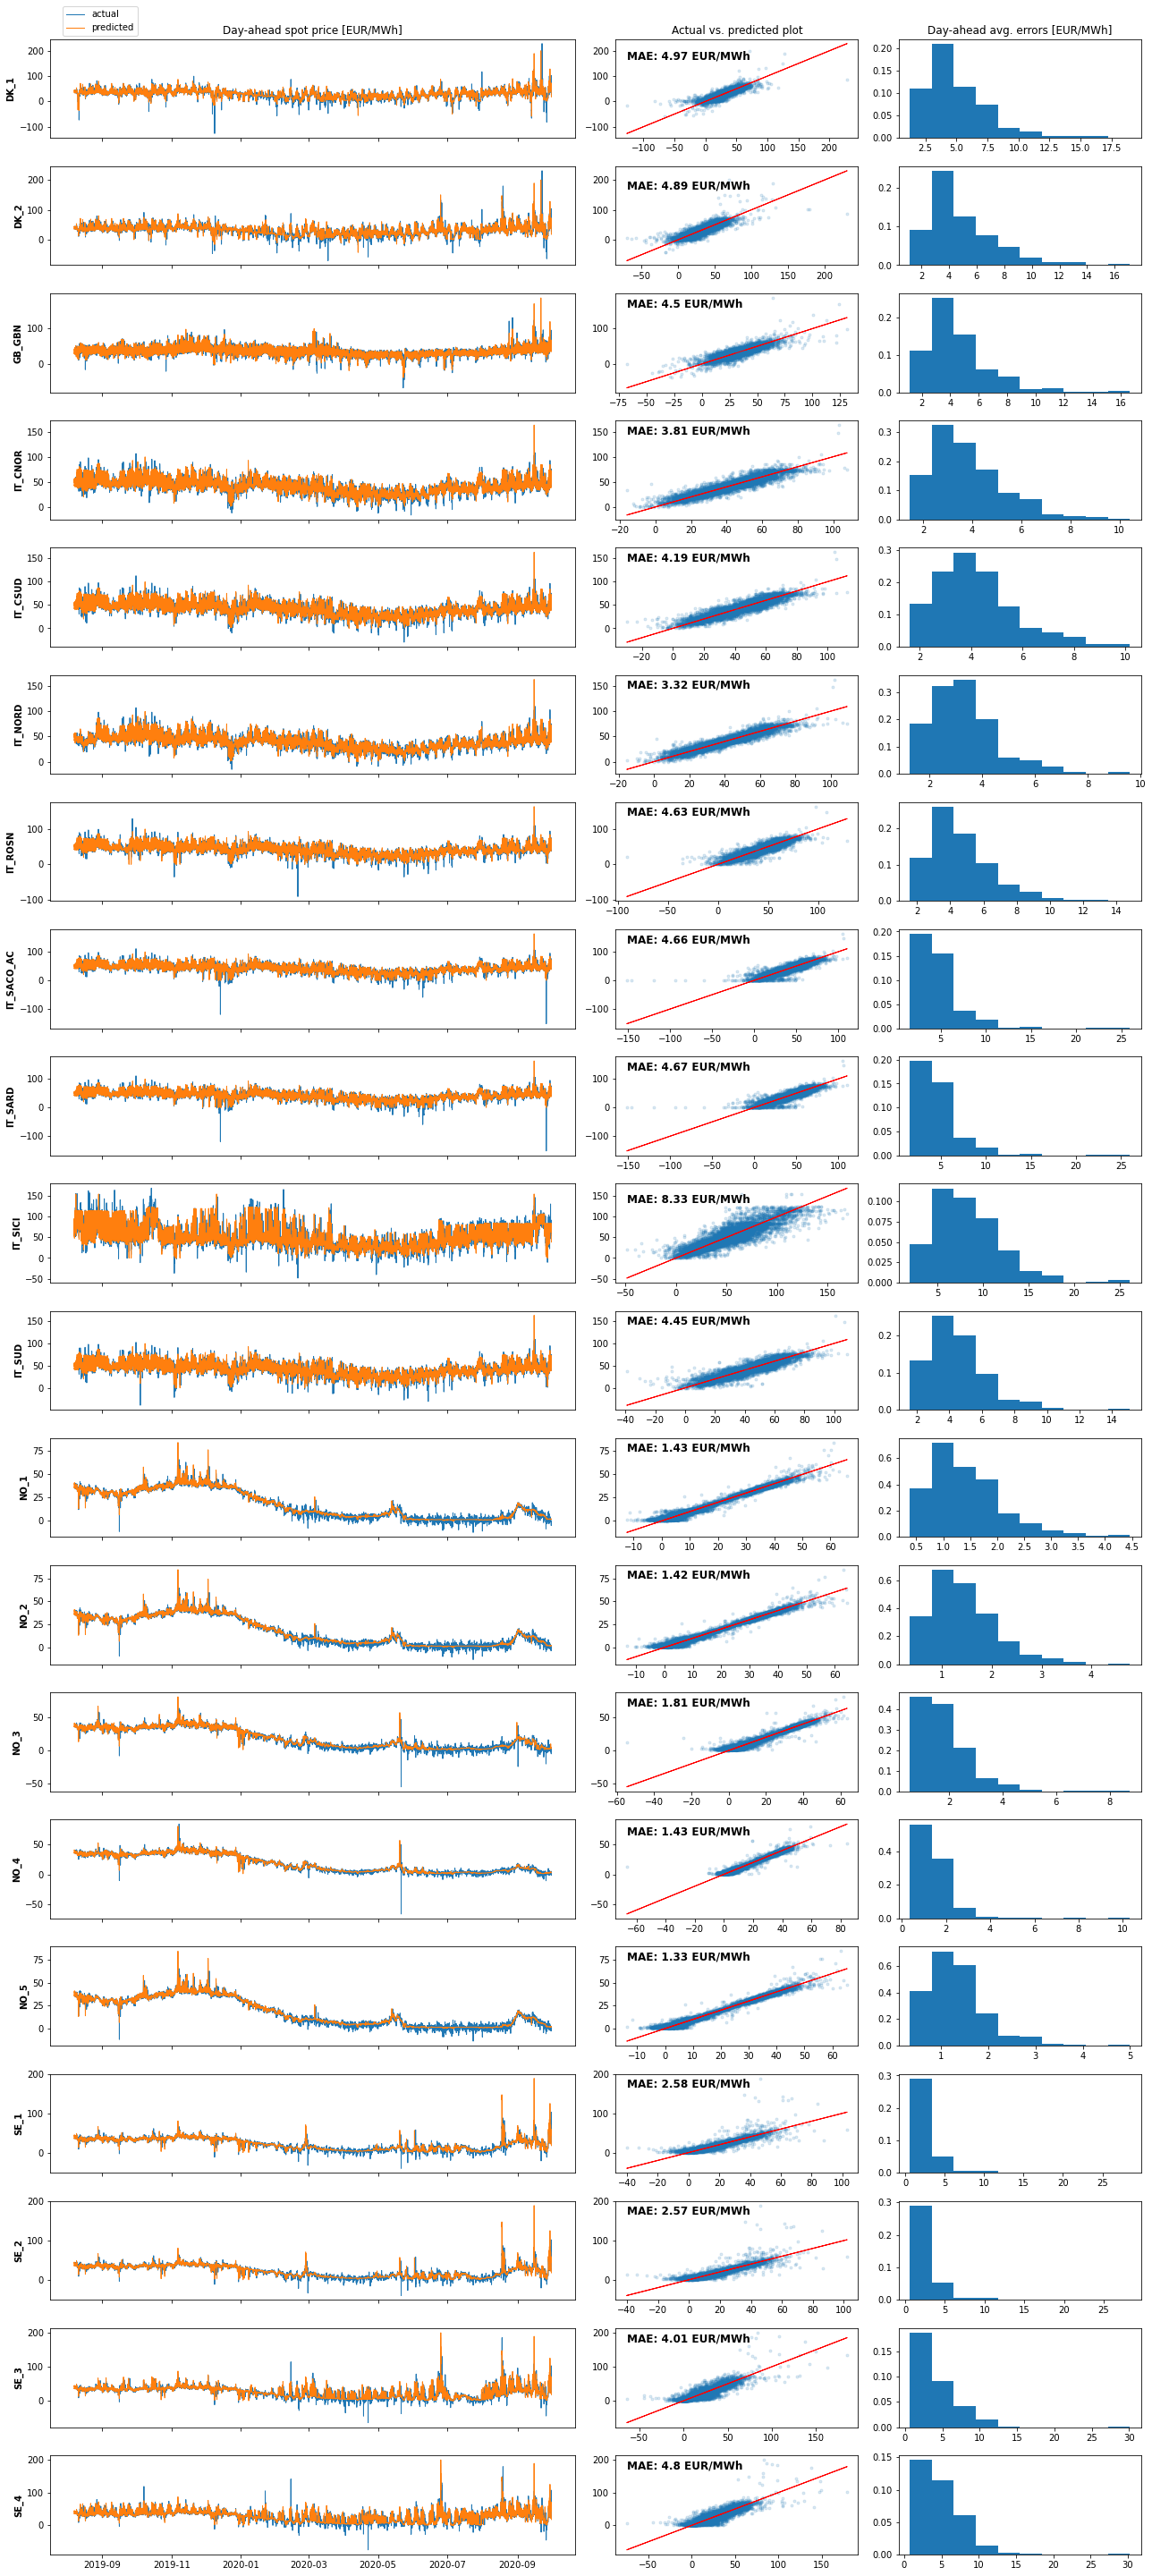

In [296]:

# Make a figure layout for the subplots
noZones = yhat.shape[1]
fig     = plt.figure(figsize = (18, 40))
gs      = fig.add_gridspec(noZones, 4)

for bidZone in range(noZones):
    
    # Grab bidzone name and data
    zName = ytest.columns[bidZone].strip('_price_day_ahead')
    act   = yhat.iloc[:, bidZone]
    pred  = ytest.iloc[:, bidZone]
    
    # Compute error
    pred.index = pred.index.tz_convert(None)                      # Forget about time-zone (next line crashes otherwise)
    err        = (act - pred).abs().dropna()                      # Compute absolute error
    errStr     = 'MAE: ' + str(err.mean().round(2)) + ' EUR/MWh'  # String for plot
    err        = err.groupby(err.index.date).mean()               # Compute daily mean absolute error
    
    # Make axes
    ax1 = plt.subplot(gs[bidZone, :-2])
    ax2 = plt.subplot(gs[bidZone, 2])
    ax3 = plt.subplot(gs[bidZone, 3])
    
    # Make plots
    ax1.plot(act, label = 'actual', linewidth = 1)
    ax1.plot(pred, label = 'predicted', linewidth = 1)
    ax1.set_ylabel(zName, fontweight = 'bold')
    
    ax2.scatter(act, pred, marker = '.', alpha = 0.15)
    ax2.plot(act, act ,color = 'red', linewidth = 1)
    ax2.text(act.min(), pred.max(), errStr, 
             fontsize            = 12, 
             fontweight          = 'bold',
             horizontalalignment = 'left',
             verticalalignment   = 'top')
       
    ax3.hist(err.values, density = True, label = 'errors');
    
    if bidZone == 0:
        ax1.legend(ncol = 1, bbox_to_anchor = (0.1752, 1.375))
        ax1.set_title('Day-ahead spot price [EUR/MWh]')
        ax2.set_title('Actual vs. predicted plot')
        ax3.set_title('Day-ahead avg. errors [EUR/MWh]')
        
    if bidZone != (noZones - 1): ax1.set_xticklabels([])

plt.tight_layout()

The results align with what is considered to be  [state-of-the-art predictions](https://doi.org/10.1016/j.apenergy.2021.116983), with a generic approach (preprocessing -> feature extraction -> modelling) that can be used on several markets directly. The errors observed can be as low as approximately 1.5 EUR/MWh or as high as 8.4 EUR/MWh, depending on the bidding zone considered.
Nevertheless, these errors are observed for a test-set spanning approximately one year.
In real-world scenarios, the models will be refitted much more regularly with lower average errors.
For instance, the 'flat-constant-value' predictions appearing on the second half of the test set on Norway's bidding zones would probably disappear with the addition of more recent data.